# Use simple matrix-based RNN to classify the language of last names



In [1]:
import pandas as pd
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
#from torch.nn.functional import softmax
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
np.set_printoptions(precision=2, suppress=True, linewidth=3000, threshold=20000)
from typing import Sequence

dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
def normal_transform(x, mean=0.0, std=0.01):
    "Convert x to have mean and std"
    return x*std + mean

def randn(n1, n2,          
          mean=0.0, std=0.01, requires_grad=False,
          device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
          dtype=torch.float64):
    x = torch.randn(n1, n2, device=device, dtype=dtype)
    x = normal_transform(x, mean=mean, std=std)
    x.requires_grad=requires_grad
    return x

In [3]:
def plot_history(history, yrange=(0.0, 5.00), figsize=(3.5,3)):
    plt.figure(figsize=figsize)
    plt.ylabel("Sentiment log loss")
    plt.xlabel("Epochs")
    loss = history[:,0]
    valid_loss = history[:,1]
    plt.plot(loss, label='train_loss')
    plt.plot(valid_loss, label='val_loss')
    # plt.xlim(0, 200)
    plt.ylim(*yrange)
    plt.legend()#loc='lower right')
    plt.show()

In [4]:
def softmax(y):
    expy = torch.exp(y)
    if len(y.shape)==1: # 1D case can't use axis arg
        return expy / torch.sum(expy)
    return expy / torch.sum(expy, axis=1).reshape(-1,1)

def cross_entropy(y_prob, y_true):
    """
    y_pred is n x k for n samples and k output classes and y_true is n x 1
    and is often softmax of final layer.
    y_pred values must be probability that output is a specific class.
    Binary case: When we have y_pred close to 1 and y_true is 1,
    loss is -1*log(1)==0. If y_pred close to 0 and y_true is 1, loss is
    -1*log(small value) = big value.
    y_true values must be positive integers in [0,k-1].
    """
    n = y_prob.shape[0]
    # Get value at y_true[j] for each sample with fancy indexing
    p = y_prob[range(n),y_true]
    return torch.mean(-torch.log(p))

## Load

Let's download [training](https://raw.githubusercontent.com/hunkim/PyTorchZeroToAll/master/data/names_train.csv.gz) and [testing](https://raw.githubusercontent.com/hunkim/PyTorchZeroToAll/master/data/names_test.csv.gz) data for last names.   This data set is a bunch of last names and the nationality or language. 

In [5]:
df_train = pd.read_csv("data/names_train.csv", header=None)
df_train.columns = ['name','language']
df_test = pd.read_csv("data/names_test.csv", header=None)
df_test.columns = ['name','language']

In [6]:
df_train.shape, df_test.shape

((13374, 2), (6700, 2))

In [7]:
df_train.head(2)

,name,language
0,Adsit,Czech
1,Ajdrna,Czech


In [8]:
# TESTING SUBSAMPLE
df_train = df_train.sample(n=2000)
df_test = df_test.sample(n=2000)

## Clean

In [9]:
badname = df_train['name']=='To The First Page' # wth?
df_train[badname].head(2)

,name,language
8347,To The First Page,Russian
8341,To The First Page,Russian


In [10]:
# probably destroying useful info but much smaller vocab
df_train['name'] = df_train['name'].str.lower()
df_test['name'] = df_test['name'].str.lower()

## Get vocab

In [11]:
def getvocab(strings):
    letters = [list(l) for l in strings]
    vocab = set([c for cl in letters for c in cl])
    vocab = sorted(list(vocab))
    ctoi = {c:i for i, c in enumerate(vocab)}
    return vocab, ctoi

In [12]:
vocab, ctoi = getvocab(df_train['name'])

## Split names into variable-length lists

In [13]:
X_train = [list(name) for name in df_train['name']]

In [14]:
df_train = df_train[df_train['name']!='To The First Page']
badname = df_test['name']=='To The First Page'
df_test = df_test[df_test['name']!='To The First Page']

## Split names into variable-length lists

In [15]:
X, y = df_train['name'], df_train['language']
X = [list(name) for name in X]
X[0:2]

[['m', 'o', 'r', 'i', 't', 'a'], ['a', 'l', 'm', 'a', 's', 'i']]

In [16]:
X_test, y_test = df_test['name'], df_test['language']
X_test = [list(name) for name in X_test]
X_test[0:2]

[['c', 'a', 'r', 'p', 'e', 'n', 't', 'e', 'r'],
 ['m', 'i', 'k', 'h', 'a', 's', 'e', 'n', 'k', 'o']]

## Split out validation set

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20)

## Encode target language (class)

Get categories from training only, not valid/test sets. Then apply cats to those set y's.

In [18]:
y_train = y_train.astype('category').cat.as_ordered()
y_cats = y_train.cat.categories
y_cats

Index(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German',
       'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish',
       'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese'],
      dtype='object')

In [19]:
y_train = torch.tensor(np.array(y_train.cat.codes.values), dtype=torch.long)
y_train[:10]

tensor([ 4, 14,  0, 10,  4, 14,  4,  4, 14, 14])

In [20]:
y_valid = torch.tensor(np.array(pd.Categorical(y_valid, categories=y_cats, ordered=True).codes),
                       dtype=torch.long)
y_test = pd.Categorical(y_test, categories=y_cats, ordered=True).codes

In [21]:
y_valid[:5], y_test[:5]

(tensor([11,  0, 14,  0, 14]), array([ 4, 14,  6, 14, 14], dtype=int8))

In [22]:
def onehot(c) -> torch.tensor:
    v = torch.zeros((len(vocab),1), dtype=torch.float64)
    v[ctoi[c]] = 1
    return v.to(device)

In [23]:
def forward1(x):
    h = torch.zeros(nhidden, 1, dtype=torch.float64, device=device, requires_grad=False)  # reset hidden state at start of record
    for j in range(len(x)):  # for each char in a name
        x_onehot = onehot(x[j])
        h = W.mm(h) + U.mm(x_onehot)# + b
#             h = torch.tanh(h)  # squish to (-1,+1)
        h = torch.relu(h)
#             print("h",h)
    # h is output of RNN, a fancy CBOW embedding for variable-length sequence in x
    # run through a final layer to map that h to a one-hot encoded predicted class
#         h = dropout(h, p=0.4)
    o = V.mm(h)# + Vb
    o = o.reshape(1,nclasses)
#     print(torch.sum(o[0]).item())
    o = softmax(o)
    return o

def forward(X:Sequence[Sequence]):#, apply_softmax=True):
    "Cut-n-paste from body of training for use with metrics"
#     outputs = torch.empty(len(X), nclasses, dtype=torch.float64).to(device)
    outputs = []
    for i in range(0, len(X)): # for each input record
        o = forward1(X[i])
        outputs.append( o[0] ) 
    return torch.stack(outputs)

In [24]:
def dropout(a:torch.tensor,   # activation/output of a layer
            p=0.0             # probability an activation is zeroed
           ) -> torch.tensor:
    usample = torch.empty_like(a).uniform_(0, 1) # get random value for each activation
    mask = (usample>p).int()                     # get mask as those with value greater than p
    a = a * mask                                 # kill masked activations
    a /= 1-p                                     # scale during training by 1/(1-p) to avoid scaling by p at test time
                                                 # after dropping p activations, (1-p) are left untouched, on average
    return a

## Model

Just some matrices. First, set up hyper parameters:

In [25]:
nhidden = 100
nfeatures = len(vocab)
nclasses = len(y_cats)
n = len(X_train)
print(f"{n:,d} training records, {nfeatures} features (chars), {nclasses} target languages, state is {nhidden}-vector")

1,600 training records, 29 features (chars), 18 target languages, state is 100-vector


## Train using pure SGD, one record used to compute gradient

Epoch:   1 accum loss  1.9213 accur 0.466 | train loss  1.6518 accur 0.471 | valid loss  1.5268 accur 0.533
Epoch:   2 accum loss  1.5667 accur 0.525 | train loss  1.3558 accur 0.596 | valid loss  1.2935 accur 0.652
Epoch:   3 accum loss  1.3529 accur 0.587 | train loss  1.1750 accur 0.638 | valid loss  1.1813 accur 0.670
Epoch:   4 accum loss  1.2020 accur 0.637 | train loss  1.0602 accur 0.669 | valid loss  1.1335 accur 0.702
Epoch:   5 accum loss  1.0759 accur 0.671 | train loss  0.9419 accur 0.697 | valid loss  1.1040 accur 0.723
Epoch:   6 accum loss  0.9711 accur 0.697 | train loss  0.8868 accur 0.706 | valid loss  1.1056 accur 0.725
Epoch:   7 accum loss  0.8872 accur 0.719 | train loss  0.8385 accur 0.733 | valid loss  1.1840 accur 0.705
Epoch:   8 accum loss  0.8248 accur 0.738 | train loss  0.7331 accur 0.760 | valid loss  1.0659 accur 0.720
Epoch:   9 accum loss  0.7318 accur 0.760 | train loss  0.7528 accur 0.769 | valid loss  1.1374 accur 0.717
Epoch:  10 accum loss  0.714

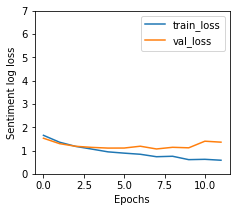

CPU times: user 27.9 s, sys: 325 ms, total: 28.3 s
Wall time: 28.3 s


In [26]:
%%time 
#torch.manual_seed(0) # SET SEED FOR TESTING
W = torch.eye(nhidden, nhidden,   dtype=torch.float64, device=device, requires_grad=True)
U = randn(nhidden,     nfeatures, dtype=torch.float64, device=device, requires_grad=True) # embed one-hot char vec
V = randn(nclasses,    nhidden,   dtype=torch.float64, device=device, requires_grad=True) # take RNN output (h) and predict target

optimizer = torch.optim.Adam([W,U,V], lr=0.001, weight_decay=0.0)

history = []
epochs = 12
for epoch in range(1, epochs+1):
#     print(f"EPOCH {epoch}")
    epoch_training_loss = 0.0
    epoch_training_accur = 0.0
    for i in range(0, n): # an epoch trains all input records
        x = X_train[i]
        h = torch.zeros(nhidden, 1, dtype=torch.float64, device=device, requires_grad=False)  # reset hidden state at start of record
        for j in range(len(x)):  # for each char in a name
            h = W.mm(h) + U.mm(onehot(x[j]))
            h = torch.relu(h)
        # h is output of RNN, a fancy CBOW embedding for variable-length sequence in x
        # run through a final layer to map that h to a one-hot encoded predicted class
#         h = dropout(h, p=0.3)
        o = V.mm(h)
        o = o.reshape(1,nclasses)
        o = softmax(o)

        loss = cross_entropy(o, y_train[i])
        optimizer.zero_grad()
        loss.backward() # autograd computes U.grad, M.grad, ...
        optimizer.step()

        epoch_training_loss += loss.detach().item()
        correct = torch.argmax(o[0])==y_train[i]
        epoch_training_accur += correct

    epoch_training_loss /= n
    epoch_training_accur /= n
#     print(f"Epoch {epoch:3d} training loss {epoch_training_loss:7.4f} accur {epoch_training_accur:7.4f}")

    with torch.no_grad():
        o = forward(X_train)#, apply_softmax=False)
        train_loss = cross_entropy(o, y_train)
        correct = torch.argmax(o, dim=1).detach().cpu()==y_train
        train_accur = torch.sum(correct) / float(len(X_train))

        o = forward(X_valid)
        valid_loss = cross_entropy(o, y_valid)
        correct = torch.argmax(o, dim=1).detach().cpu()==y_valid
        valid_accur = torch.sum(correct) / float(len(X_valid))

        history.append((train_loss, valid_loss))
        print(f"Epoch: {epoch:3d} accum loss {epoch_training_loss:7.4f} accur {epoch_training_accur:4.3f} | train loss {train_loss:7.4f} accur {train_accur:4.3f} | valid loss {valid_loss:7.4f} accur {valid_accur:4.3f}")

history = torch.tensor(history)
plot_history(history, yrange=(0,7))

## Train using mini-batch SGD, multiple records used to compute gradient

Still w/o vectorization, one record at a time. Just do a batch before computing gradients.

In [27]:
nhidden = 100
nfeatures = len(vocab)
nclasses = len(y_cats)
batch_size = 32
n = len(X_train)
print(f"{n:,d} training records, {nfeatures} features (chars), {nclasses} target languages, state is {nhidden}-vector")

1,600 training records, 29 features (chars), 18 target languages, state is 100-vector


Epoch:   1 accum loss     nan accur 0.150 | train loss     nan accur 0.090 | valid loss     nan accur 0.093
Epoch:   2 accum loss     nan accur 0.090 | train loss     nan accur 0.090 | valid loss     nan accur 0.093
Epoch:   3 accum loss     nan accur 0.090 | train loss     nan accur 0.090 | valid loss     nan accur 0.093
Epoch:   4 accum loss     nan accur 0.090 | train loss     nan accur 0.090 | valid loss     nan accur 0.093
Epoch:   5 accum loss     nan accur 0.090 | train loss     nan accur 0.090 | valid loss     nan accur 0.093
Epoch:   6 accum loss     nan accur 0.090 | train loss     nan accur 0.090 | valid loss     nan accur 0.093
Epoch:   7 accum loss     nan accur 0.090 | train loss     nan accur 0.090 | valid loss     nan accur 0.093
Epoch:   8 accum loss     nan accur 0.090 | train loss     nan accur 0.090 | valid loss     nan accur 0.093
Epoch:   9 accum loss     nan accur 0.090 | train loss     nan accur 0.090 | valid loss     nan accur 0.093
Epoch:  10 accum loss     na

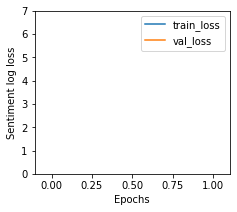

CPU times: user 22.3 s, sys: 145 ms, total: 22.4 s
Wall time: 22.5 s


In [28]:
%%time 
#torch.manual_seed(0) # SET SEED FOR TESTING
W = torch.eye(nhidden, nhidden,   dtype=torch.float64, device=device, requires_grad=True)
U = randn(nhidden,     nfeatures, dtype=torch.float64, device=device, requires_grad=True) # embed one-hot char vec
V = randn(nclasses,    nhidden,   dtype=torch.float64, device=device, requires_grad=True) # take RNN output (h) and predict target

optimizer = torch.optim.Adam([W,U,V], lr=0.005, weight_decay=0.0)

history = []
epochs = 12
for epoch in range(1, epochs+1):
#     print(f"EPOCH {epoch}")
    epoch_training_loss = 0.0
    epoch_training_accur = 0.0
    for p in range(0, n, batch_size):  # do one epoch
        loss = 0
        for i in range(p, p+batch_size): # do one batch
            x = X_train[i]
            h = torch.zeros(nhidden, 1, dtype=torch.float64, device=device, requires_grad=False)  # reset hidden state at start of record
            for j in range(len(x)):  # for each char in a name
                h = W.mm(h) + U.mm(onehot(x[j]))
                h = torch.relu(h)
            # h is output of RNN, a fancy CBOW embedding for variable-length sequence in x
            # run through a final layer to map that h to a one-hot encoded predicted class
#             h = dropout(h, p=0.3)
            o = V.mm(h)
            o = o.reshape(1,nclasses)
            o = softmax(o)
            loss += cross_entropy(o, y_train[i])
            correct = torch.argmax(o[0])==y_train[i]
            epoch_training_accur += correct

        # update matrices based upon loss computed from a batch
        optimizer.zero_grad()
        loss.backward() # autograd computes U.grad, M.grad, ...
        optimizer.step()

        epoch_training_loss += loss.detach().item()

    epoch_training_loss /= n
    epoch_training_accur /= n
#     print(f"Epoch {epoch:3d} training loss {epoch_training_loss:7.4f} accur {epoch_training_accur:7.4f}")

    with torch.no_grad():
        o = forward(X_train)#, apply_softmax=False)
        train_loss = cross_entropy(o, y_train)
        correct = torch.argmax(o, dim=1).detach().cpu()==y_train
        train_accur = torch.sum(correct) / float(len(X_train))

        o = forward(X_valid)
        valid_loss = cross_entropy(o, y_valid)
        correct = torch.argmax(o, dim=1).detach().cpu()==y_valid
        valid_accur = torch.sum(correct) / float(len(X_valid))

        history.append((train_loss, valid_loss))
        print(f"Epoch: {epoch:3d} accum loss {epoch_training_loss:7.4f} accur {epoch_training_accur:4.3f} | train loss {train_loss:7.4f} accur {train_accur:4.3f} | valid loss {valid_loss:7.4f} accur {valid_accur:4.3f}")

history = torch.tensor(history)
plot_history(history, yrange=(0,7))

## Train using vectorized mini-batch SGD

Instead of processing batch one record at a time from time 1 to time len(word), process all time steps t across all batch records at once then proceed to time step (char index) t+1.  This allows us to vectorize and perform each time step in parallel.  We effectively remove a loop.

Means we must pad to have same length in batch. pad on left so they are ignored to get same answer as record-by-record.

In [29]:
def get_max_len(X):
    max_len = 0
    for x in X:
        max_len = max(max_len, len(x))
    return max_len

In [30]:
def onehot_matrix(X, max_len, vocab, verbose=False):
    X_onehot = torch.zeros((len(X),max_len,len(vocab)), dtype=torch.float64)
    for i,x in enumerate(X):
        pad = max_len - len(x)
        for j,c in enumerate(x):
            X_onehot[i, j+pad, ctoi[c]] = 1
        if verbose: print(x); print(X_onehot[i].T, "\n")
    return X_onehot

## Test with trivial data set

Set TESTING=True to test vs full X_train

In [37]:
TESTING = False

nhidden = 100
batch_size = 32

if TESTING:
    nhidden = 2
    batch_size = 2

    X_train = [['a','b'],['c','d','e'], # batch 1
               ['f'],['c','a'], # batch 2
               ['e']] # strip
    y_train = [0,2,1,1,2]

    X_valid = X_train
    y_valid = y_train

In [52]:
n = len(X_train)

nbatches = n // batch_size
n = nbatches * batch_size
X_train = X_train[0:n]
y_train = y_train[0:n]
vocab, ctoi = getvocab(X)
max_len = get_max_len(X)
nfeatures = len(vocab)
nclasses = len(torch.unique(torch.tensor(y_train)))

print(f"{n:,d} training records, batch size {batch_size}, {nfeatures} features (chars), {nclasses} target languages, state is {nhidden}-vector")

1,600 training records, batch size 32, 29 features (chars), 18 target languages, state is 100-vector


/Users/parrt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [53]:
X_onehot = onehot_matrix(X_train, max_len, vocab, verbose=False)

With verbose and trivial X_train we get:

```
['a', 'b']
tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64) 

['c', 'd', 'e']
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 0.]], dtype=torch.float64) 

['f']
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 1.]], dtype=torch.float64) 

['c', 'a']
tensor([[0., 0., 1.],
        [0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64) 
```

In [54]:
def forward(X:Sequence[Sequence], max_len:int, vocab:dict):
    "Cut-n-paste from body of training for use with metrics"
    X_onehot = onehot_matrix(X, max_len, vocab)
    h = torch.zeros(nhidden, len(X), dtype=torch.float64, device=device, requires_grad=False)
    for j in range(max_len):
        x_step_t = X_onehot[:,j].T
        h = W.mm(h) + U.mm(x_step_t)
        h = torch.relu(h)        
    o = V.mm(h)
    o = o.T # make it batch_size x nclasses
    o = softmax(o)
    return o

/Users/parrt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/parrt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   1 accum loss  2.2246 accur 0.461 | train loss  1.9119 accur 0.465 | valid loss  1.9377 accur 0.525
Epoch:   2 accum loss  1.8960 accur 0.465 | train loss  1.7842 accur 0.465 | valid loss  1.7029 accur 0.525
Epoch:   3 accum loss  1.7857 accur 0.465 | train loss  1.7101 accur 0.465 | valid loss  1.5942 accur 0.525
Epoch:   4 accum loss  1.7221 accur 0.466 | train loss  1.6590 accur 0.474 | valid loss  1.5432 accur 0.545
Epoch:   5 accum loss  1.6703 accur 0.484 | train loss  1.6154 accur 0.498 | valid loss  1.5115 accur 0.558
Epoch:   6 accum loss  1.6312 accur 0.496 | train loss  1.5691 accur 0.511 | valid loss  1.4784 accur 0.572
Epoch:   7 accum loss  1.5889 accur 0.522 | train loss  1.5162 accur 0.537 | valid loss  1.4469 accur 0.608
Epoch:   8 accum loss  1.5425 accur 0.541 | train loss  1.4762 accur 0.553 | valid loss  1.4163 accur 0.605
Epoch:   9 accum loss  1.5077 accur 0.556 | train loss  1.4460 accur 0.562 | valid loss  1.3966 accur 0.615
Epoch:  10 accum loss  1.472

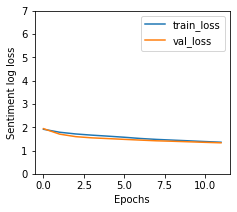

CPU times: user 39.7 s, sys: 1.87 s, total: 41.6 s
Wall time: 6.22 s


In [70]:
%%time 
#torch.manual_seed(0) # SET SEED FOR TESTING
W = torch.eye(nhidden, nhidden,   dtype=torch.float64, device=device, requires_grad=True)
U = randn(nhidden,     nfeatures, dtype=torch.float64, device=device, requires_grad=True) # embed one-hot char vec
V = randn(nclasses,    nhidden,   dtype=torch.float64, device=device, requires_grad=True) # take RNN output (h) and predict target

optimizer = torch.optim.Adam([W,U,V], lr=0.001, weight_decay=0.0)

history = []
epochs = 12
for epoch in range(1, epochs+1):
#     print(f"EPOCH {epoch}")
    epoch_training_loss = 0.0
    epoch_training_accur = 0.0
    total = 0
    for p in range(0, n, batch_size):  # do one epoch
        loss = 0
        batch_X = X_train[p:p+batch_size]
        batch_y = y_train[p:p+batch_size]
        batch_X_onehot = onehot_matrix(batch_X, max_len, vocab)
        h = torch.zeros(nhidden, batch_size, dtype=torch.float64, device=device, requires_grad=False)
        for j in range(max_len):
            x_step_t = batch_X_onehot[:,j].T # make it len(vocab) x batch_size
            h = W.mm(h) + U.mm(x_step_t)
            h = torch.relu(h)        
        o = V.mm(h)
        o = o.T # make it batch_size x nclasses
        o = softmax(o)
        loss = cross_entropy(o, batch_y)
        correct = torch.argmax(o, dim=1)==batch_y
        epoch_training_accur += torch.sum(correct)
        total += len(batch_y)

        # update matrices based upon loss computed from a batch
        optimizer.zero_grad()
        loss.backward() # autograd computes U.grad, M.grad, ...
        optimizer.step()

        epoch_training_loss += loss.detach().item()

    epoch_training_loss /= nbatches
    epoch_training_accur /= n
#     print(f"Epoch {epoch:3d} training loss {epoch_training_loss:7.4f} accur {epoch_training_accur:7.4f}")

    with torch.no_grad():
        o = forward(X_train, max_len, vocab)#, apply_softmax=False)
        train_loss = cross_entropy(o, y_train).item()
        correct = torch.argmax(o, dim=1).detach().cpu()==torch.tensor(y_train)
        train_accur = torch.sum(correct) / float(len(X_train))

        o = forward(X_valid, max_len, vocab)
        valid_loss = cross_entropy(o, y_valid).item()
        correct = torch.argmax(o, dim=1).detach().cpu()==torch.tensor(y_valid)
        valid_accur = torch.sum(correct) / float(len(X_valid))

        history.append((train_loss, valid_loss))
        print(f"Epoch: {epoch:3d} accum loss {epoch_training_loss:7.4f} accur {epoch_training_accur:4.3f} | train loss {train_loss:7.4f} accur {train_accur:4.3f} | valid loss {valid_loss:7.4f} accur {valid_accur:4.3f}")

history = torch.tensor(history)
plot_history(history, yrange=(0,7))